## Dando Vida à Equação

Este notebook implementa nosso primeiro Perceptron funcional em sua forma mais simples possível: **uma única camada com um único neurônio**. Usaremos apenas Python e NumPy para ver a teoria dos Capítulos 1, 2 e 3 em sua forma mais pura.

O objetivo é aplicar a retropropagação (_backpropagation_) a um problema real, mas bem rudimentar, de classificação de imagens. Como nossa arquitetura é a mais simples que existe, veremos como as equações gerais do aprendizado se simplificam de uma maneira bela e intuitiva. O cálculo do gradiente dos pesos (`∂E/∂W`), por exemplo, não precisará do produto externo, como veremos.

Este é o alicerce. Ao entender este código, você entenderá o que os frameworks modernos fazem por baixo dos panos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Função para baixar e preparar uma imagem a partir de uma URL
def download_and_prepare_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('L')
    img_array = np.array(img) / 255.0
    img_array = np.where(img_array > 0.7, 1, 0)
    return img_array.flatten()

# URLs das imagens de "carinhas"
base_url = 'https://raw.githubusercontent.com/aleperrod/perceptron-book/2e9af4436dd7317ea18fbcae583429cccc944ef0/carinhas/'
urls = [
    base_url + 'gross1.png', base_url + 'gross2.png', base_url + 'gross3.png',
    base_url + 'thin1.png',  base_url + 'thin2.png',  base_url + 'thin3.png'
]

X_train = np.array([download_and_prepare_image(url) for url in urls])
z_train = np.array([0, 0, 0, 1, 1, 1])

# Imagens de teste
url_teste_thin = base_url + 'thin4.png'
url_teste_gross = base_url + 'gross4.png'
x_teste_thin = download_and_prepare_image(url_teste_thin)
x_teste_gross = download_and_prepare_image(url_teste_gross)

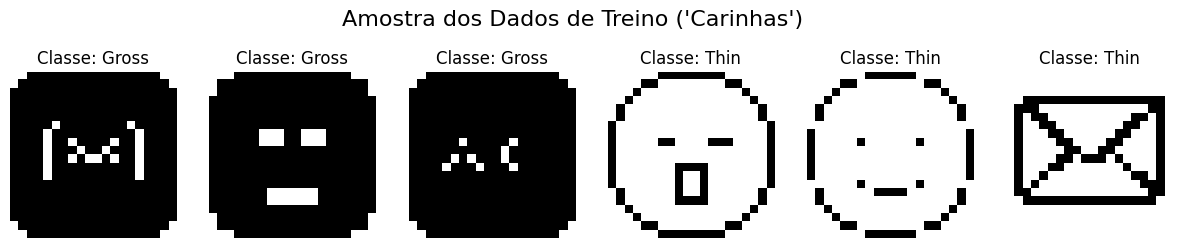

In [2]:
# Visualizando nossos dados de treino
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(20, 20), cmap='gray')
    ax.set_title(f"Classe: {'Gross' if z_train[i] == 0 else 'Thin'}")
    ax.axis('off')
plt.suptitle("Amostra dos Dados de Treino ('Carinhas')", fontsize=16)
plt.show()

### Passo 2: Definindo as Ferramentas (Funções)

Como estamos construindo tudo "na mão", definimos nossas ferramentas como funções separadas. Note que, como nosso Perceptron tem um só neurônio, a saída `P` e o erro `E` são valores únicos (escalares), o que simplifica suas derivadas.

In [3]:
# Funções de Ativação e suas derivadas
def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def sigmoid_derivative(a):
    return a * (1 - a)

# Função de Custo (Erro Quadrado Médio) e sua derivada
# z e P são escalares aqui
def mean_squared_error(z, P):
    return (z - P)**2

def mean_squared_error_derivative(z, P):
    return 2 * (P - z) # Mantendo o fator 2 para fidelidade à derivada formal

# Função para inicializar os parâmetros do nosso neurônio
def inicializar_parametros(dim_entrada):
    # W é um vetor 1D (não uma matriz) com 400 pesos.
    W = np.random.randn(dim_entrada) * 0.01
    # b é um único número (escalar)
    b = 0.0
    return W, b

### Passo 3: O Treino "Na Mão" (Exemplo por Exemplo)

Este é o coração do nosso notebook. O loop de treino implementa a teoria do aprendizado do zero. Para cada imagem `x` e seu rótulo `z`, o processo é:

1.  **Forward Pass:** Calculamos a saída `P`, que neste caso é um único número.
2.  **Backpropagation:** Calculamos os gradientes. Aqui está a beleza da simplificação:
    * O "delta" do erro `dE/dy` é um escalar.
    * O gradiente do peso, `dE/dW`, é calculado multiplicando este delta escalar pelo vetor de entrada `x`. A equação `∂E/∂W = (∂E/∂a * ∂a/∂y) * x` se manifesta aqui. Não precisamos de produto externo, apenas de uma multiplicação elemento a elemento.
3.  **Atualização:** Ajustamos `W` e `b` usando os gradientes calculados.

In [4]:
# --- Hiperparâmetros e Inicialização ---
taxa_aprendizagem = 0.1
epocas = 30
W, b = inicializar_parametros(X_train.shape[1])

historico_custo = []

print("Iniciando o treino em Python/NumPy (versão corrigida)...")
for i in range(epocas):
    custo_total_epoca = 0
    # O loop interno itera sobre cada exemplo individualmente
    for x, z in zip(X_train, z_train):

        # --- 1. Forward Pass ---
        # y = W . x + b (produto escalar entre dois vetores -> escalar)
        y = np.dot(W, x) + b
        # P = a(y) (ativação sobre um escalar -> escalar)
        P = sigmoid(y)

        # --- 2. Cálculo do Custo ---
        custo = mean_squared_error(z, P)
        custo_total_epoca += custo

        # --- 3. Backpropagation (com escalares) ---
        # Delta inicial: dE/dy = dE/dP * dP/dy (produto de escalares)
        dE_dP = mean_squared_error_derivative(z, P)
        dP_dy = sigmoid_derivative(P)
        dE_dy = dE_dP * dP_dy

        # Gradientes dos parâmetros
        # dE/dW = dE/dy * d(y)/dW = dE/dy * x
        # Esta é a forma simplificada! É a multiplicação de um escalar (dE_dy) por um vetor (x).
        dE_dW = dE_dy * x
        # dE/db = dE/dy * d(y)/db = dE/dy * 1
        dE_db = dE_dy

        # --- 4. Atualização dos Parâmetros ---
        W -= taxa_aprendizagem * dE_dW
        b -= taxa_aprendizagem * dE_db

    # Fim da época
    custo_medio = custo_total_epoca / len(X_train)
    historico_custo.append(custo_medio)
    if (i + 1) % 5 == 0:
      print(f"Época {i + 1}/{epocas} - Custo Médio: {custo_medio.item():.6f}")

print("Treino finalizado!")

Iniciando o treino em Python/NumPy (versão corrigida)...
Época 5/30 - Custo Médio: 0.008507
Época 10/30 - Custo Médio: 0.003716
Época 15/30 - Custo Médio: 0.002356
Época 20/30 - Custo Médio: 0.001718
Época 25/30 - Custo Médio: 0.001349
Época 30/30 - Custo Médio: 0.001109
Treino finalizado!


### Passo 4: Analisando os Resultados do Treino

Uma coisa é executar o treino, outra é saber se ele funcionou. O gráfico abaixo mostra a evolução do custo médio ao longo das épocas.

Uma curva descendente é o sinal que procuramos: ela indica que o Perceptron estava, a cada passagem pelos dados, ajustando seus pesos e se tornando progressivamente melhor em sua tarefa, ou seja, o erro estava diminuindo.

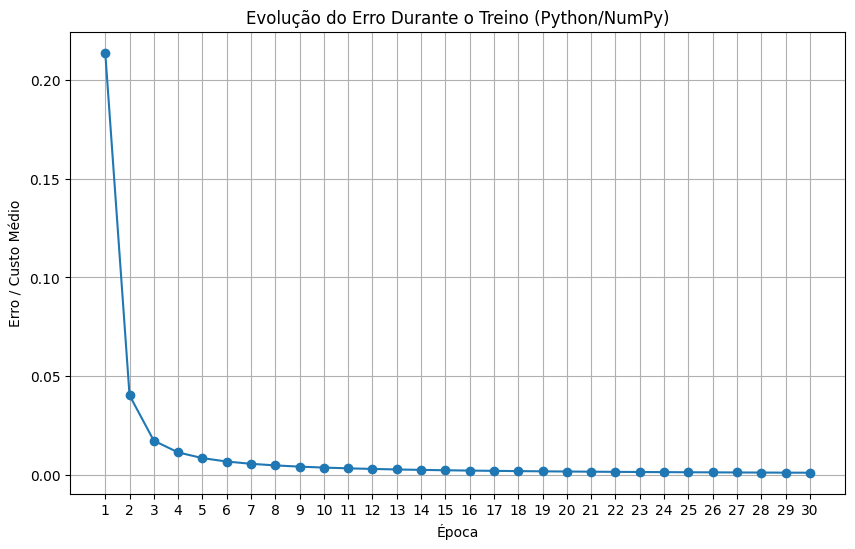

In [5]:
# Plotar o gráfico da função de custo para ver se a rede aprendeu
plt.figure(figsize=(10, 6))
plt.plot(historico_custo, marker='o', linestyle='-')
plt.xlabel("Época")
plt.ylabel("Erro / Custo Médio")
plt.title("Evolução do Erro Durante o Treino (Python/NumPy)")
plt.grid(True)
plt.xticks(np.arange(len(historico_custo)), np.arange(1, len(historico_custo) + 1))
plt.show()

### Passo 5: Testando o Modelo na Prática

Após o treinamento, o verdadeiro teste de uma rede neural é seu desempenho em dados que ela nunca viu antes. A célula abaixo define uma função que pega uma imagem de teste, aplica o _forward pass_ com os pesos `W` e o bias `b` que acabamos de treinar, e exibe a imagem com a predição do modelo ao lado do rótulo real.

A saída da função Sigmoid (`P`) é um número entre 0 e 1. Podemos interpretá-lo como a "confiança" do neurônio de que a imagem pertence à classe "Thin" (rótulo 1). Usamos um limiar (threshold) de 0.5 para tomar a decisão final.

Execute a célula para ver se o Perceptron acerta!

Iniciando testes com dados não vistos...

--- Testando a imagem: 'Thin' ---
Saída do neurônio (P): 0.9828
Predição final: Thin


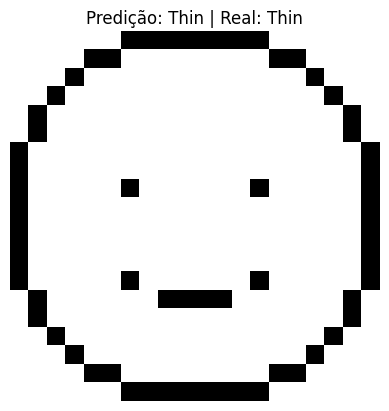



--- Testando a imagem: 'Gross' ---
Saída do neurônio (P): 0.1138
Predição final: Gross


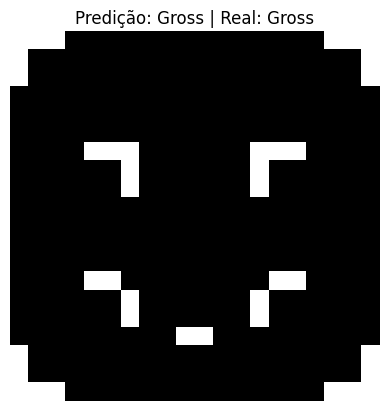

In [9]:
# Função para testar o modelo treinado em uma nova imagem
def testar_modelo_numpy(imagem, label_real_str, W, b):
    # O Forward Pass é o mesmo que dentro do loop de treino
    y = np.dot(W, imagem) + b
    P = sigmoid(y)

    # A classificação é baseada em um limiar (threshold) de 0.5
    predicao_final = "Thin" if P > 0.5 else "Gross"

    # Exibindo os resultados
    print(f"--- Testando a imagem: '{label_real_str}' ---")
    print(f"Saída do neurônio (P): {P.item():.4f}")
    print(f"Predição final: {predicao_final}")

    plt.imshow(imagem.reshape(20, 20), cmap='gray')
    plt.title(f"Predição: {predicao_final} | Real: {label_real_str}")
    plt.axis('off')
    plt.show()

# Testando com as duas imagens que separamos
print("Iniciando testes com dados não vistos...\n")
testar_modelo_numpy(x_teste_thin, "Thin", W, b)
print("\n" + "="*40 + "\n")
testar_modelo_numpy(x_teste_gross, "Gross", W, b)